# Programming Lab 5 - Deep Learning

***
##### CS 434 - Data Mining and Machine Learning
##### Oregon State University-Cascades
***

In [268]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [269]:
name = "Austin Martin"   # <== fill in
assert name != ""
print(name+'\'s Lab 5 submission')

Austin Martin's Lab 5 submission


***
# Load packages
***

Any additional packages you need for this lab should be added here.

**DO NOT** import packages anywhere else!

In [270]:
# packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
from scipy.stats.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans


<ipython-input-270-3bceaf289b9c>:15: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


***
# Objective
***

This is an open-ended lab in which you will explore TensorFlow on a problem of your choosing.

1.  Pick a dataset
2.  Build a tensorflow deep learning model
3.  Train and test your model
4.  Analyze your results
5.  Write a report

> **Submission**: run the entire notebook before submission.  I will **not** re-run it to grade.

***
# Data
***

##### Protips

A good strategy is to read several related articles on a topic (e.g., image classification with CNN) and **interpolate** an approach that combines aspects from each source. Then, apply this approach on on an entirely **different dataset** not used in the articles.
> Be sure to cite any sources that you draw inspiration from.

> You may not directly copy someone else's code - plagiarism detection is very easy. All of the usual academic honestly policies apply.

> * Choose something that interests you.  It makes the lab more fun.
>
> * Determine your problem type
>   * e.g., classification, regression, auto-regression, reinforcement
>
> * Split to train/validation/test and use each appropriately.
>
> * Some datasets are very large. You do not have to use ALL of it (i.e. subsample).
>   * size is problem dependent, but look to Activies 18-20 for guidance
>
>
> * Develop your approach on a (very?) small subset of data (for speed) and scale up after you finish your empirical design.
>
> * Look at our Activities and [Towards Data Science](https://towardsdatascience.com/) articles for ideas and inspiration.

In [271]:
#  url of the data zip file
url = 'https://github.com/Soundbendor/cs434/raw/master/lab3-deezer.zip'
zip_file = 'lab3-deezer.zip'

# fetch zip file if not already fetched
!get $url

# unzip file if not already unzipped
!unzip $zip_file

/bin/bash: line 1: get: command not found
unzip:  cannot find or open lab3-deezer.zip, lab3-deezer.zip.zip or lab3-deezer.zip.ZIP.


### Load dataset

In [272]:
# load your dataset
df_spot = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/deezer_spotify.csv')
df_meta = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/deezer_metadata.csv')
df_tags = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/deezer_lastfm_best_tag.csv')

### Pre-process dataset

In [273]:
# function to graph data - used in lab 3
def plot_val_vs_aro(valence, arousal, colors='b', plt_size=14, dot_size=20):
    """
    Plot a scatterplot of Valance vs Arousal with labels for each corresponding emotion.

    Args:
        valence (list): list of valance values
        arousal (list): list of arousal values
        colors (str, optional): matplotlib.pyplot color code. Defaults to 'b' for blue tones.
        plt_size (int, optional): plot figure size. Defaults to 14.
        dot_size (int, optional): data point size. Defaults to 20.
    """
    title = 'Valence vs. Arousal'
    x_label = 'Valence'
    y_label = 'Arousal'

    plt.figure(figsize=(plt_size,plt_size))
    plt.scatter(valence, arousal, s=dot_size, c=colors, alpha=.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.xlim(-1.25,1.25)
    plt.ylim(-1.25,1.25)

    # draw the unit circle
    fig = plt.gcf()
    ax = fig.gca()
    circle1 = plt.Circle((0, 0), 1.0, color='0.25', fill=False)
    ax.add_artist(circle1)

    # print emotion labels
    plt.text(0.98, 0.35, 'Happy', fontsize=plt_size)
    plt.text(0.5, 0.9, 'Excited', fontsize=plt_size)
    plt.text(-1.16, 0.35, 'Afraid', fontsize=plt_size)
    plt.text(-0.7, 0.9, 'Angry', fontsize=plt_size)
    plt.text(-1.13, -0.25, 'Sad', fontsize=plt_size)
    plt.text(-0.9, -0.9, 'Depressed', fontsize=plt_size)
    plt.text(0.98, -0.25, 'Content', fontsize=plt_size)
    plt.text(0.7, -0.9, 'Calm', fontsize=plt_size)


    plt.show()

# function to graph data - used in lab 3
def plot_true_vs_pred(true, pred, x_label, y_label, title, colors='b', plt_size=14, dot_size=20) :
    """
    Plot true vs predicted with a regression line of best fit. Can be used for valance OR arousal.

    Args:
        true (list): True values
        pred (list): predicted valaues
        x_label (str): label for true values.
        y_label (str): label for predicted values.
        title (str): title of chart
        colors (str, optional): matplotlib.pyplot color code. Defaults to 'b' for blue tones.
        plt_size (int, optional): plot figure size. Defaults to 14.
        dot_size (int, optional): data point size. Defaults to 20.
    """
    plt.figure(figsize=(plt_size,plt_size))
    plt.scatter(true, pred, s=dot_size, c=colors, alpha=.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # draw the regression line
    m, b = np.polyfit(true, pred, 1)
    plt.plot(true, m*true + b, color='red', linewidth=2)

    plt.show()

In [274]:
# Normalize valence and arousal to (-1,1)
df_meta['valence'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(df_meta['valence']).reshape(-1,1))
df_meta['arousal'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(df_meta['arousal']).reshape(-1,1))

In [275]:
#merge dataframes to create one dataframe with all features and target classes
df_feats = pd.merge(df_meta, df_tags)
df_feats = pd.merge(df_feats, df_spot)

# drop features that are not needed
df_feats = df_feats.drop(['MSD_track_id', 'dzr_sng_id', 'MSD_sng_id', 'track_name', 'artist_name','lastfm_tag'], axis=1)
df_spot = df_spot.drop(['MSD_track_id'], axis=1)
df_tags = df_tags.drop(['MSD_track_id','lastfm_tag'], axis=1)

In [276]:
display(df_feats)
display(df_spot)
display(df_tags)

,valence,arousal,lastfm_tag_rank,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit
0,-0.206795,0.041667,189,0.001620,0.315,412000.0,0.7950,0.196000,6.0,0.0776,-9.645,0.0,0.0574,138.293,3.0,0.413,18.0,False
1,-0.595273,0.521739,172,0.000010,0.171,440320.0,0.7980,0.029500,11.0,0.0759,-5.548,0.0,0.0622,110.058,4.0,0.130,19.0,False
2,-0.884786,-0.340580,34,0.924000,0.579,360640.0,0.0972,0.001050,10.0,0.0766,-13.925,1.0,0.0477,78.526,4.0,0.354,9.0,False
3,0.604136,0.177536,9,0.008590,0.710,171747.0,0.9630,0.013300,11.0,0.2180,-4.787,0.0,0.0277,129.965,4.0,0.968,51.0,False
4,0.843427,0.344203,21,0.082700,0.491,148400.0,0.7110,0.000064,10.0,0.2460,-6.463,1.0,0.0330,119.001,4.0,0.545,22.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,-0.680945,0.657609,189,0.000090,0.174,209507.0,0.9880,0.898000,0.0,0.7200,-3.420,0.0,0.1070,126.399,4.0,0.103,27.0,True
18640,-0.497784,0.170290,2,0.000019,0.693,513520.0,0.7310,0.020700,11.0,0.0737,-6.666,1.0,0.0483,130.033,4.0,0.602,22.0,False
18641,0.800591,0.382246,56,0.133000,0.533,156093.0,0.8330,0.000000,0.0,0.2280,-7.706,1.0,0.0334,128.399,4.0,0.581,23.0,False
18642,-0.266765,-0.162319,19,0.150000,0.472,382297.0,0.3660,0.308000,11.0,0.0837,-12.595,0.0,0.0286,127.167,4.0,0.171,75.0,False


,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit
0,0.131000,0.460,278267.0,0.772,0.041700,0.0,0.0527,-9.233,1.0,0.0445,138.002,4.0,0.532,53.0,False
1,0.394000,0.520,299613.0,0.253,0.000131,0.0,0.1090,-12.407,1.0,0.0344,139.555,3.0,0.219,60.0,False
2,0.056200,0.909,219840.0,0.740,0.000000,1.0,0.0593,-2.361,1.0,0.2600,97.855,4.0,0.802,54.0,True
3,0.905000,0.701,223613.0,0.202,0.000157,1.0,0.1070,-12.480,1.0,0.0609,85.389,4.0,0.477,53.0,False
4,0.818000,0.499,298237.0,0.201,0.000001,11.0,0.1430,-12.145,1.0,0.0276,72.139,4.0,0.234,48.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,0.000090,0.174,209507.0,0.988,0.898000,0.0,0.7200,-3.420,0.0,0.1070,126.399,4.0,0.103,27.0,True
18640,0.000019,0.693,513520.0,0.731,0.020700,11.0,0.0737,-6.666,1.0,0.0483,130.033,4.0,0.602,22.0,False
18641,0.133000,0.533,156093.0,0.833,0.000000,0.0,0.2280,-7.706,1.0,0.0334,128.399,4.0,0.581,23.0,False
18642,0.150000,0.472,382297.0,0.366,0.308000,11.0,0.0837,-12.595,0.0,0.0286,127.167,4.0,0.171,75.0,False


,lastfm_tag_rank
0,0
1,0
2,0
3,0
4,0
...,...
18639,498810
18640,500920
18641,501681
18642,506032


In [277]:
#clean up data frames to get ready for training and Kmeans clustering
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

df_spot = pd.DataFrame(imp.fit_transform(df_spot), columns=df_spot.columns)
df_feats = pd.DataFrame(imp.fit_transform(df_feats), columns=df_feats.columns)

#encode categorical data
le = LabelEncoder()

df_feats['sp_explicit'] = le.fit_transform(df_feats['sp_explicit'])
df_spot['sp_explicit'] = le.fit_transform(df_spot['sp_explicit'])

***
# Workspace
***

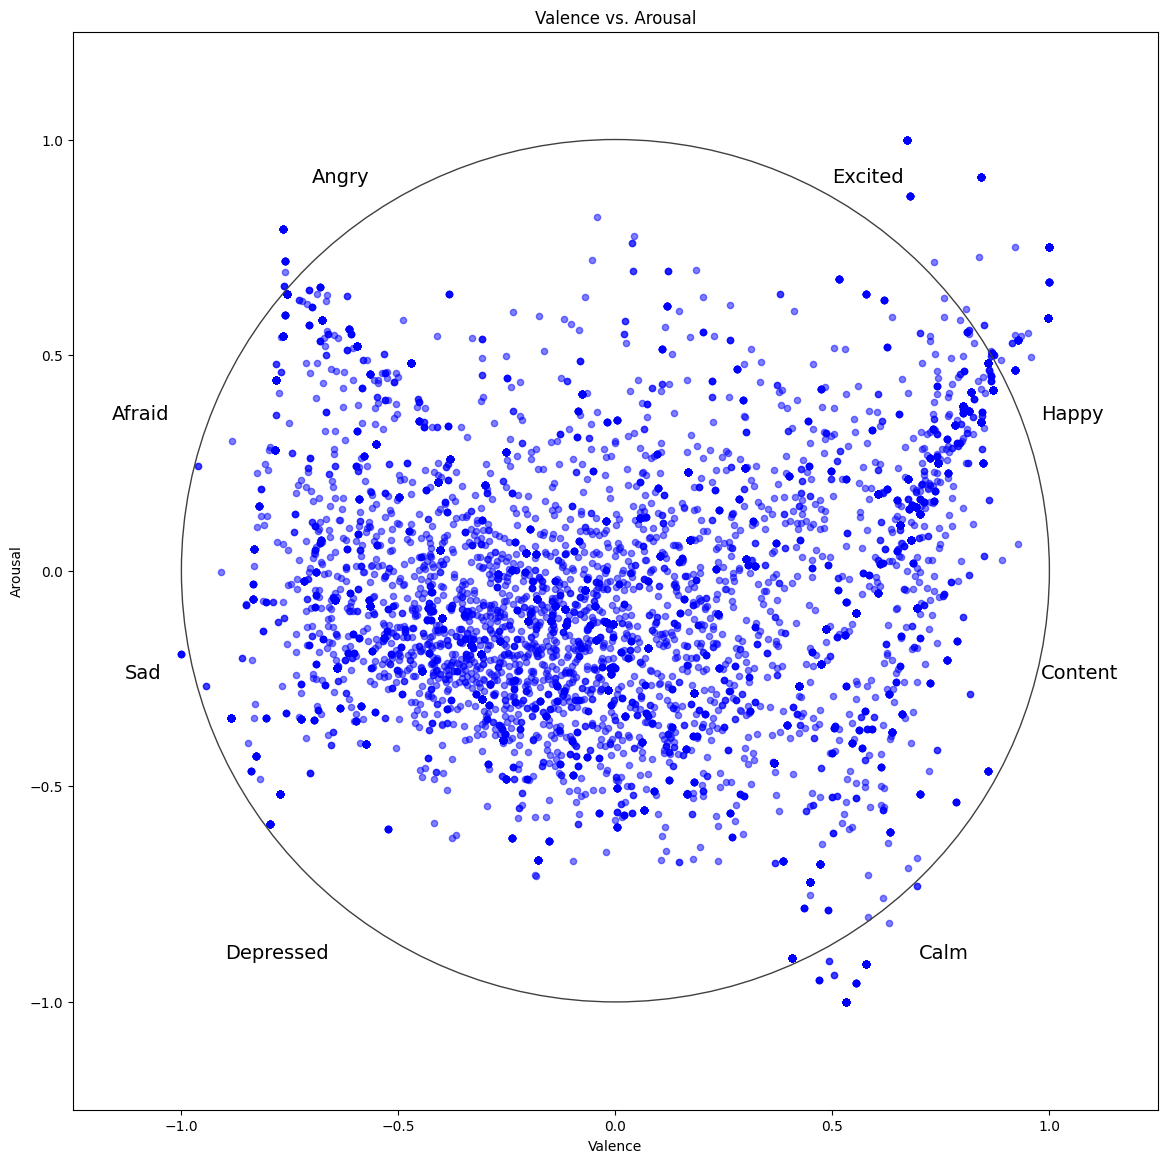

In [278]:
## view our valence-arousal space for our examples
plot_val_vs_aro(df_feats['valence'], df_feats['arousal'])

In [279]:

def elbow_method(feats):
# Elbow method to determine optimal number of clusters
    dist_acoustic = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=1)
        kmeans.fit(feats)
        dist_acoustic.append(kmeans.inertia_)
    plt.plot(range(1, 11), dist_acoustic)
    plt.xlabel('Number of clusters')
    plt.ylabel('distortion')
    plt.title('Elbow Method - df_acoustic')
    plt.show()

In [280]:
display(df_tags)

,lastfm_tag_rank
0,0
1,0
2,0
3,0
4,0
...,...
18639,498810
18640,500920
18641,501681
18642,506032


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

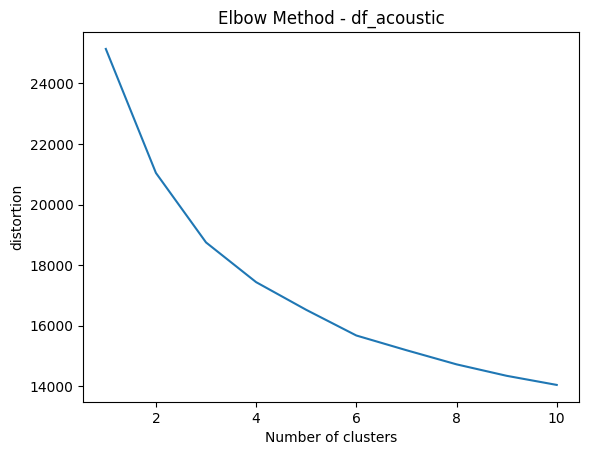

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

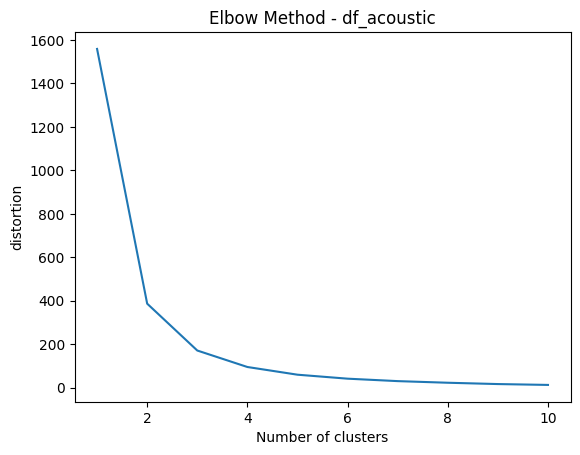

In [281]:
from sklearn.preprocessing import QuantileTransformer

# Transform the features using QuantileTransformer
qt = QuantileTransformer(random_state=1)
spot = qt.fit_transform(df_spot.values)
tags = qt.fit_transform(df_tags.values)

elbow_method(spot)
elbow_method(tags)

In [282]:
y_km_spot = KMeans(n_clusters=6, random_state=1).fit_predict(spot)
y_km_tags = KMeans(n_clusters=3, random_state=1).fit_predict(tags)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [283]:
def print_clusters(n, y_km):
    # print number of examples in each cluster for each feature subset
    clust_name = 'spot'
    for i in range(n):
        print(f'{clust_name} cluster {i+1}: {np.count_nonzero(y_km == i)} examples')

    print()

In [284]:
print_clusters(6, y_km_spot)
print_clusters(3, y_km_tags)

spot cluster 1: 3484 examples
spot cluster 2: 4445 examples
spot cluster 3: 1628 examples
spot cluster 4: 2985 examples
spot cluster 5: 2350 examples
spot cluster 6: 3752 examples

spot cluster 1: 6357 examples
spot cluster 2: 6147 examples
spot cluster 3: 6140 examples



In [285]:
df_feats['spot_cluster'] = y_km_spot
df_feats['tags_cluster'] = y_km_tags

In [286]:
# split data into training and testing sets
X = df_feats.drop(['valence', 'arousal'], axis=1)
y_valence = df_feats['valence']
y_arousal = df_feats['arousal']

In [287]:
display(df_feats)
display(X)

,valence,arousal,lastfm_tag_rank,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit,spot_cluster,tags_cluster
0,-0.206795,0.041667,189.0,0.001620,0.315,412000.0,0.7950,0.196000,6.0,0.0776,-9.645,0.0,0.0574,138.293,3.0,0.413,18.0,0,5,0
1,-0.595273,0.521739,172.0,0.000010,0.171,440320.0,0.7980,0.029500,11.0,0.0759,-5.548,0.0,0.0622,110.058,4.0,0.130,19.0,0,1,0
2,-0.884786,-0.340580,34.0,0.924000,0.579,360640.0,0.0972,0.001050,10.0,0.0766,-13.925,1.0,0.0477,78.526,4.0,0.354,9.0,0,5,0
3,0.604136,0.177536,9.0,0.008590,0.710,171747.0,0.9630,0.013300,11.0,0.2180,-4.787,0.0,0.0277,129.965,4.0,0.968,51.0,0,1,0
4,0.843427,0.344203,21.0,0.082700,0.491,148400.0,0.7110,0.000064,10.0,0.2460,-6.463,1.0,0.0330,119.001,4.0,0.545,22.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,-0.680945,0.657609,189.0,0.000090,0.174,209507.0,0.9880,0.898000,0.0,0.7200,-3.420,0.0,0.1070,126.399,4.0,0.103,27.0,2,2,1
18640,-0.497784,0.170290,2.0,0.000019,0.693,513520.0,0.7310,0.020700,11.0,0.0737,-6.666,1.0,0.0483,130.033,4.0,0.602,22.0,0,0,1
18641,0.800591,0.382246,56.0,0.133000,0.533,156093.0,0.8330,0.000000,0.0,0.2280,-7.706,1.0,0.0334,128.399,4.0,0.581,23.0,0,5,1
18642,-0.266765,-0.162319,19.0,0.150000,0.472,382297.0,0.3660,0.308000,11.0,0.0837,-12.595,0.0,0.0286,127.167,4.0,0.171,75.0,0,4,1


,lastfm_tag_rank,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit,spot_cluster,tags_cluster
0,189.0,0.001620,0.315,412000.0,0.7950,0.196000,6.0,0.0776,-9.645,0.0,0.0574,138.293,3.0,0.413,18.0,0,5,0
1,172.0,0.000010,0.171,440320.0,0.7980,0.029500,11.0,0.0759,-5.548,0.0,0.0622,110.058,4.0,0.130,19.0,0,1,0
2,34.0,0.924000,0.579,360640.0,0.0972,0.001050,10.0,0.0766,-13.925,1.0,0.0477,78.526,4.0,0.354,9.0,0,5,0
3,9.0,0.008590,0.710,171747.0,0.9630,0.013300,11.0,0.2180,-4.787,0.0,0.0277,129.965,4.0,0.968,51.0,0,1,0
4,21.0,0.082700,0.491,148400.0,0.7110,0.000064,10.0,0.2460,-6.463,1.0,0.0330,119.001,4.0,0.545,22.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,189.0,0.000090,0.174,209507.0,0.9880,0.898000,0.0,0.7200,-3.420,0.0,0.1070,126.399,4.0,0.103,27.0,2,2,1
18640,2.0,0.000019,0.693,513520.0,0.7310,0.020700,11.0,0.0737,-6.666,1.0,0.0483,130.033,4.0,0.602,22.0,0,0,1
18641,56.0,0.133000,0.533,156093.0,0.8330,0.000000,0.0,0.2280,-7.706,1.0,0.0334,128.399,4.0,0.581,23.0,0,5,1
18642,19.0,0.150000,0.472,382297.0,0.3660,0.308000,11.0,0.0837,-12.595,0.0,0.0286,127.167,4.0,0.171,75.0,0,4,1


In [288]:
# split data into training and testing sets for valence and arousal
X_train, X_test, y_train, y_test = train_test_split(X, y_valence, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_arousal, test_size=0.2, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=.25, random_state=42)

In [289]:
# scale data
qt = QuantileTransformer()
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)
X_val = qt.transform(X_val)


In [290]:
# create neural network with skip connection
input_layer = layers.Input(shape=(X_train.shape[1],))
x = layers.Dense(32, activation='tanh')(input_layer)
x = layers.Dropout(0.2)(x)

# Skip connection
skip = x  # Save the output of this layer to connect to the final output

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='tanh')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
# Add the skip connection
x = layers.Add()([x, skip])

output_layer = layers.Dense(1, activation='tanh')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

# make a decaying learning rate
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

optimizer = keras.optimizers.Adam(learning_rate=.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [291]:
# Train the Neural Network - Valence
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), callbacks=[callback])
model.evaluate(X_test, y_test)

y_valence_preds = model.predict(X_test)
y_valence_preds = y_valence_preds.reshape(-1)
# get pearson correlation
corr, _ = pearsonr(y_valence_preds, y_test)
print('Pearsons correlation: %.3f' % corr)

Epoch 1/50
700/700 [==============================] - 6s 6ms/step - loss: 0.5643 - mae: 0.5993 - val_loss: 0.3289 - val_mae: 0.4549 - lr: 0.0010
Epoch 2/50
700/700 [==============================] - 4s 6ms/step - loss: 0.3637 - mae: 0.4934 - val_loss: 0.2802 - val_mae: 0.4480 - lr: 0.0010
Epoch 3/50
700/700 [==============================] - 5s 8ms/step - loss: 0.3064 - mae: 0.4654 - val_loss: 0.2828 - val_mae: 0.4530 - lr: 9.5123e-04
Epoch 4/50
700/700 [==============================] - 4s 6ms/step - loss: 0.2929 - mae: 0.4547 - val_loss: 0.2778 - val_mae: 0.4418 - lr: 9.0484e-04
Epoch 5/50
700/700 [==============================] - 4s 6ms/step - loss: 0.2914 - mae: 0.4539 - val_loss: 0.2773 - val_mae: 0.4379 - lr: 8.6071e-04
Epoch 6/50
700/700 [==============================] - 8s 11ms/step - loss: 0.2878 - mae: 0.4505 - val_loss: 0.2775 - val_mae: 0.4352 - lr: 8.1873e-04
Epoch 7/50
700/700 [==============================] - 4s 6ms/step - loss: 0.2864 - mae: 0.4474 - val_loss: 0.2784

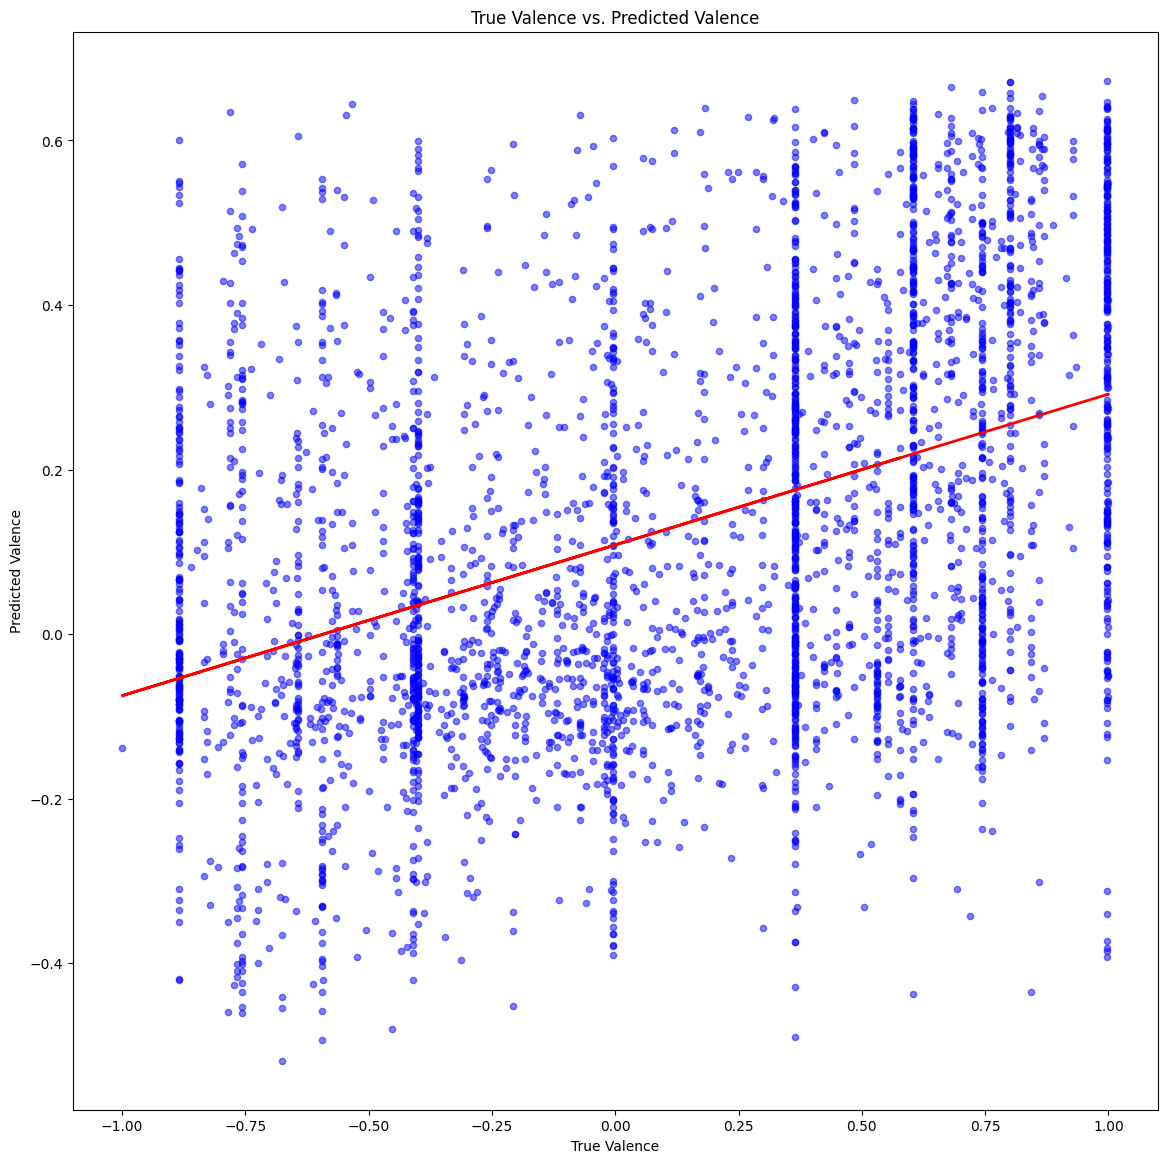

In [292]:
# Graph Results

# plot true valence vs predicted valence
plot_true_vs_pred(y_test, y_valence_preds, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence')


---
#                          **REPORT**
---

# **Predicting Valence With Deep Learning**


---



# Introduction

A few weeks ago we examined a problem where we tried to predict the Valence and Arousal of music (emotional evokation of a piece of music) from a set of spotify data attached to approximately 18000 songs. The spotify data consisted of tags attached to the music such as 'dancability' or 'acousticness'. During this project, I used a couple of of regressor machine models to try to accomplish the highest possible pearson R score (or correlation rate) between the true and predicted values. After spending that past few weeks learning about clustering and then nueral networks. I wanted to revisit this problem and see if I could improve upon the pearson R scores previsouly observed. The idea was to use Kmeans clustering to manufacture some more impactful features that could help better inform a learning model. This model would be a neural network that, in theory, should be more flexible and better at observing deep patterns within the data than the simpler models used in the last attempt. Please see the previous project for more in depth information and background context. Link Here: https://github.com/Koookadooo/Valence_Arousal

# Data and Preprocessing


Data retrieval was done by obtain the necessary file from the following source:

'https://github.com/Soundbendor/cs434/raw/master/lab3-deezer.zip'

Once unzipped, The following files were used to create pandas dataframes:

*   deezer_spotify.csv
*   deezer_metadata.csv
*   deezer_lastfm_best_tag.csv

These 3 dataframes were merged into 1 dataframe called df_feats. Then the same features were removed from this dataset as were during the previous project. Before the merge, the Valence and Arousal features normalized to values between -1 and 1. See below:




In [293]:
# # Normalize valence and arousal to (-1,1)
# df_meta['valence'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(df_meta['valence']).reshape(-1,1))
# df_meta['arousal'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(df_meta['arousal']).reshape(-1,1))

# #merge dataframes to create one dataframe with all features and target classes
# df_feats = pd.merge(df_meta, df_tags)
# df_feats = pd.merge(df_feats, df_spot)

# # drop features that are not needed
# df_feats = df_feats.drop(['MSD_track_id', 'dzr_sng_id', 'MSD_sng_id', 'track_name', 'artist_name','lastfm_tag'], axis=1)
# df_spot = df_spot.drop(['MSD_track_id'], axis=1)
# df_tags = df_tags.drop(['MSD_track_id','lastfm_tag'], axis=1)

I also used a simple Imputer to impute any missing values using the column average as the value to be imputer. This fills out our data and was also a step we took in the previous project.

In [294]:
# #clean up data frames to get ready for training and Kmeans clustering
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# df_spot = pd.DataFrame(imp.fit_transform(df_spot), columns=df_spot.columns)
# df_feats = pd.DataFrame(imp.fit_transform(df_feats), columns=df_feats.columns)

# #encode categorical data
# le = LabelEncoder()

# df_feats['sp_explicit'] = le.fit_transform(df_feats['sp_explicit'])
# df_spot['sp_explicit'] = le.fit_transform(df_spot['sp_explicit'])

What I did not do last time, however, was label encode the sp_explicit feature, which is the only feature that is not a float value. This should not necessarily change the outcome in and of itself, but it was necessary for the next step of my data processing.

I then used ***KMeans*** to make clusters out of the two individual dataframes that makeup df_feats, df_spot, and df_tags (df_meta was not used as it not only contains our target data - valence and arousal). Before applying KMeans, I used a quantile transformer to tranform the feature data in the individual dataframes. This helps to regulate the data and handle outliers, making it easier to cluster effectively. I then used the elbow method to get an approximate number of cluster to make for each individual dataset and applied KMeans. See below:

In [295]:
# # create clusters
# y_km_spot = KMeans(n_clusters=6, random_state=1).fit_predict(spot)
# y_km_tags = KMeans(n_clusters=3, random_state=1).fit_predict(tags)

# # add them as features to df_feats
# df_feats['spot_cluster'] = y_km_spot
# df_feats['tags_cluster'] = y_km_tags

I also made sure to check the distribution of the clusters as a measure of goodness before adding them to my dataframe as new features. The idea here was to create some more impactful patterns using patterns kmeans already found the data to help inform a deep learning model.

After that was complete, I split the dataframe into X, y_valence, and y_arousal and then split those into train, test, and validate sets and used a Quantile Transformer to transform X_train, X_test, and X_val. This was for the same reasoning as above, the help reduce noise in the potentially noisy data. Time to build a model.

# Methods

In order to get an idea of where we were starting out at, the first model that was built contained 2 hidden Dense Layers with 8 nodes a piece and 'relu' activations, along with an ouput layer with 1 node and no activation function. I Used default optimizer and learning rate and ran the model for 10 epochs. I then used the model to predict x_test and compare those preds to y_test and got a Pearson R value of 0.345 - Not a great start, but a start.

I then tried running the same model for 20 epoch to observe what happened. I noticed that the model would quickly start overfitting. Our test loss and test mae would decrease on every epoch, but the validate loss and validate mae would only decrease for the first 5 or so epoch and then start diverging. This is when I added in a bach normalization layer and a dropout layer to help combat the overfitting. This helped immediately, with the overfitting, but I was still only getting pearson R scores of ~ 0.345. Time to add more layers and up our node counts.

The next iteration saw me add in two more hidden Dense Layers. Each hidden layer now had 16 nodes and 'relu' activations. I also added a tanh activation to the output layer as it forces the output to be between -1 and 1 which is our target range. Each hidden layer also had a dropout layer attached with a dropout rate of 0.2. The last hidden layer also had a batch normalization layer. This configuration started to imporve my result but only marginally to a pearson R correlation of about 0.367. I noticed during training that the validation loss and mae would go do significanlty to start and then bounce around with relatively large margins. This made me think that the learning was getting stuck in a local minima and that I should perhaps try changing the optimizer and learning rate.

After a few different attempts to change the learning rate without much success (it would either make little to no progress when it was low or make progress and then start jumping around as described above) I thought it might be a good idea to try a decaying learning rate as they can help you to take those first large steps in learning and then help to avoid getting stuck in local minimas.

The addition of a decaying learning rate with an adam optimizer helped my model converge more smoothly and completely as I was now seeing pearson R scores right around 0.39, which is still not great but we were making progress.

After a few more tweaks I ended up with my second to last model. This one would have 1 dense layer with 32 nodes and tanh activation, followed by 3 dense layers with 128 nodes and relu activation, followed by another dense layer with 32 nodes and tanh. Each of these hidden layers had a dropout rate of 0.2 and the last hidden layer had a batch normalization attached to it. The output layer remained the same as the previous iterations. Dense, 1 node, tanh activation. This combined with 50 epochs and a batch size of 16 got me above the 0.4 pearson R mark.

With my ideas running out, I thought I would try one more approach. I remember reading about how sometimes when we learn deep pattern in the data we overlook shallow patterns that may be there. I added a skip layer into my model then went from the frist hidden dense layer (with 32 nodes) to the last hidden dense layer right before the output layer. See my final model below:

In [296]:
# # create neural network with skip connection
# input_layer = layers.Input(shape=(X_train.shape[1],))
# x = layers.Dense(32, activation='tanh')(input_layer)
# x = layers.Dropout(0.2)(x)

# # Skip connection
# skip = x  # Save the output of this layer to connect to the final output

# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(32, activation='tanh')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
# # Add the skip connection
# x = layers.Add()([x, skip])

# output_layer = layers.Dense(1, activation='tanh')(x)

# model = models.Model(inputs=input_layer, outputs=output_layer)

# # make a decaying learning rate
# def scheduler(epoch, lr):
#     if epoch < 2:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.05)

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# optimizer = keras.optimizers.Adam(learning_rate=.001)

# model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Results

My final model gave me the following results:

*   Pearson R: ~0.420
*   Test Loss: ~0.2697
*   Test MAE: ~0.4295


See code below:




In [297]:
print('Pearsons correlation: %.3f' % corr)
model.evaluate(X_test, y_test)

Pearsons correlation: 0.416
117/117 [==============================] - 0s 3ms/step - loss: 0.2696 - mae: 0.4277


[0.26964086294174194, 0.4277212619781494]

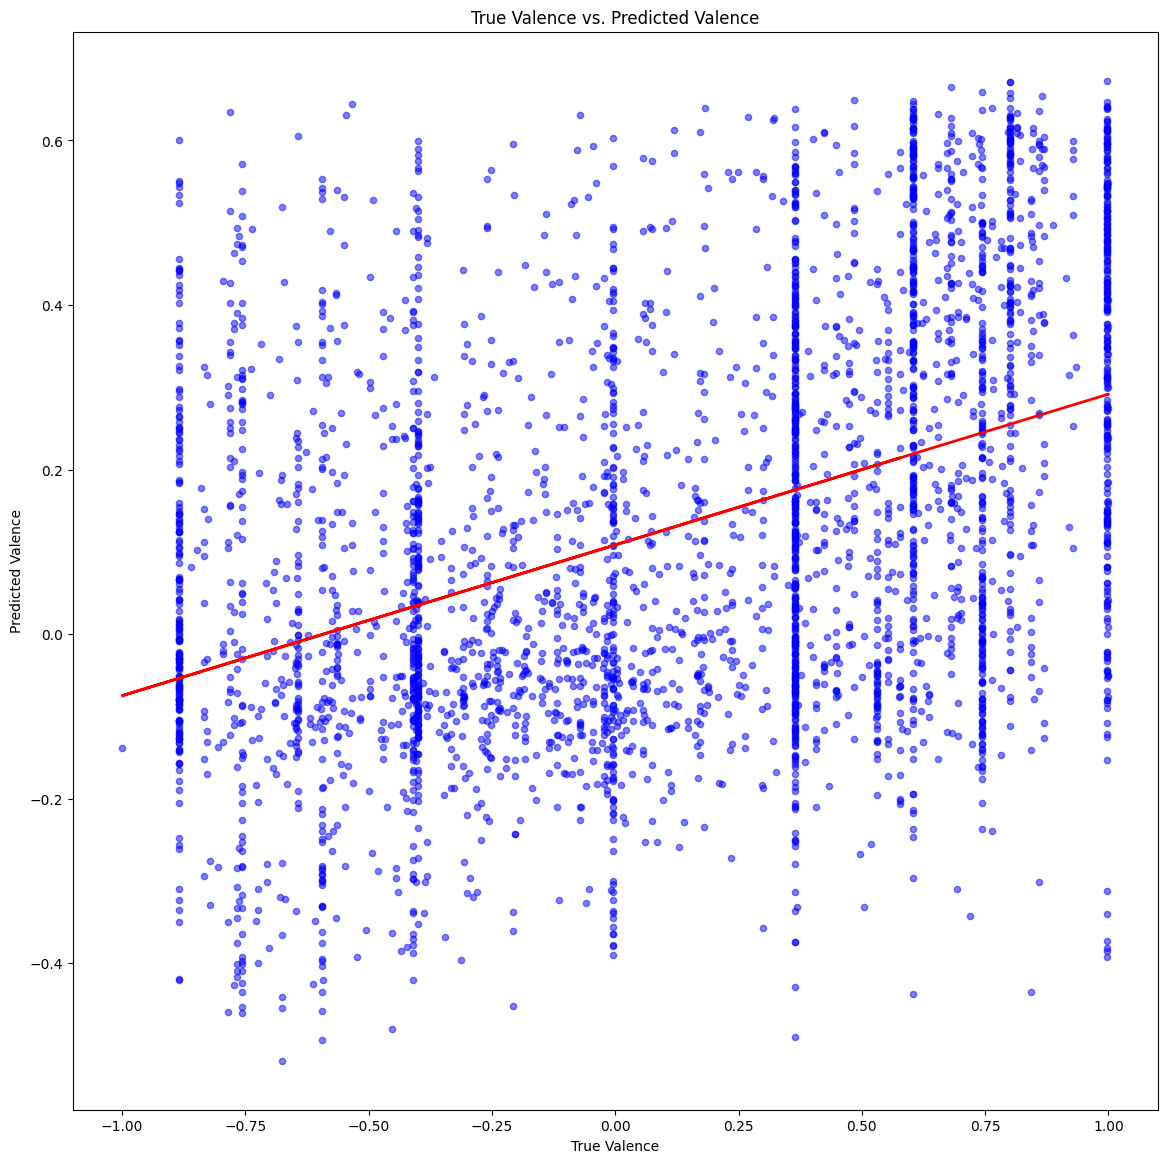

In [298]:
# Graph Results

# plot true valence vs predicted valence
plot_true_vs_pred(y_test, y_valence_preds, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence')

# Discussion & Conclusion

The results were below my expectations. I was able to achieve a much higher Pearson R score with much less effort using a Histogram Gradient Boosting Regressor in the last project, which yielded a Pearson R of 0.57. There are a couple of reasons why I think this might be.



1.   I was looking for deep patterns that may not have existed:
The histo gram gradient boosting regressor uses many tree 'stumps' (only using one or two features each time) to make a decision, but each tree stump is built upon a loss gradient from the last tree stump. The neural net take into acount every feature every time and then wait until then end to back propogate the loss gradient through the layers and their nodes. I think the randomized feature tree stumps combined with the 'on the go' gradient boosting helped to make some sense of the noisy data.

2.   I am still a long way from understanding neural nets as well as I would like to be and could have totally missed the correct approach to this problem. I look forward to expanding my knowledge more so that I can revisit this one day.

3.  The spotify data set does not hold features that can explain or predict the valence in music very well. I know it is a hard problem to begin with, but it is possible that the data doesn't give us enough information.

In conclusion, I really would like to revisit this set again at somepoint with more knowledge of neural nets to see if this can in fact be cracked!

